### This notebook was used as a prototyping platform for developing the initial sample generator placed in sample_generator.py and generate_samples.py. Each step and trial is contained in named sections of better understanding.

In [4]:
import numpy as np
from pathlib import Path

from src.features.signal import lofar
from src.visualization import waterfall_spectrogram
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
def spectrum_noise(spectrum_func, samples=1024, rate=44100):
    """ 
    make noise with a certain spectral density
    """
    freqs = np.fft.rfftfreq(samples, 1.0/rate)            # real-fft frequencies (not the negative ones)
    spectrum = np.zeros_like(freqs, dtype='complex')      # make complex numbers for spectrum
    spectrum[1:] = spectrum_func(freqs[1:])               # get spectrum amplitude for all frequencies except f=0
    phases = np.random.uniform(0, 2*np.pi, len(freqs)-1)  # random phases for all frequencies except f=0
    spectrum[1:] *= np.exp(1j*phases)                     # apply random phases
    noise = np.fft.irfft(spectrum)                        # return the reverse fourier transform
    noise = np.pad(noise, (0, samples - len(noise)), 'constant') # add zero for odd number of input samples
 
    return noise
 
def pink_spectrum(f, f_min=0, f_max=np.inf, att=np.log10(2.0)*10):
    """
    Define a pink (1/f) spectrum
        f     = array of frequencies
        f_min = minimum frequency for band pass
        f_max = maximum frequency for band pass
        att   = attenuation per factor two in frequency in decibel.
                Default is such that a factor two in frequency increase gives a factor two in power attenuation.
    """
    # numbers in the equation below explained:
    #  0.5: take the square root of the power spectrum so that we get an amplitude (field) spectrum 
    # 10.0: convert attenuation from decibel to bel
    #  2.0: frequency factor for which the attenuation is given (octave)
    s = f**-( 0.5 * (att/10.0) / np.log10(2.0) )  # apply attenuation
    s[np.logical_or(f < f_min, f > f_max)] = 0    # apply band pass
    return s

## Single sine with noise

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7f25cab99730>)

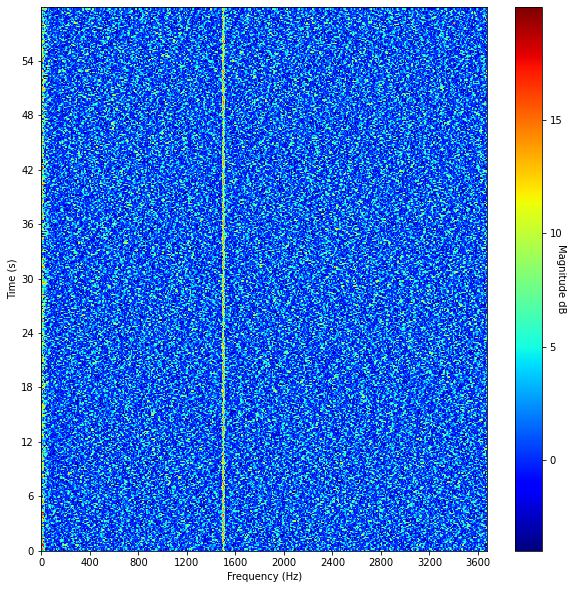

In [6]:
seconds = 60
sample_rate = 22050
f = 1500
t = np.linspace(0, seconds, seconds*sample_rate)
# noise = voss(t.shape[0], 100)
noise = 30e04*spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(2.0)*10), seconds*sample_rate, sample_rate)

x = np.sin(2*np.pi*f*t) + noise
x = x[:, np.newaxis] 
sxx, freq, time = lofar(x, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

## Random amplitude sine with noise

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1fcd130>)

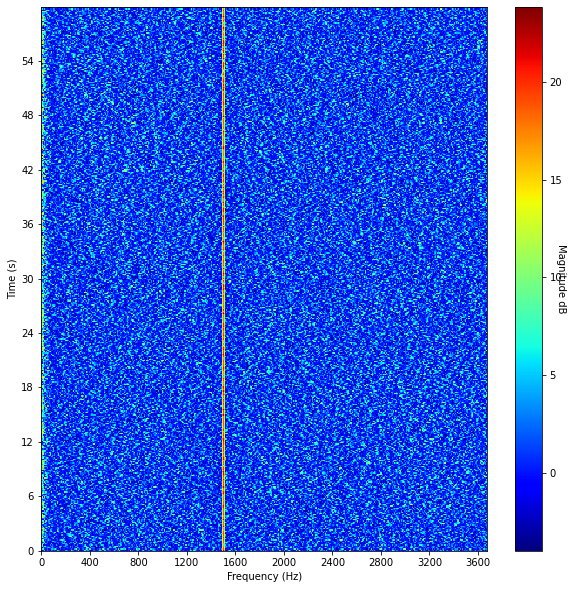

In [4]:
seconds = 60
sample_rate = 22050
f = 1500
t = np.linspace(0, seconds, seconds*sample_rate)
# noise = voss(t.shape[0], 100)
noise = 30e04*spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(2.0)*10), seconds*sample_rate, sample_rate)

amplitude = np.random.lognormal(mean=0, sigma=1.5, size=seconds*sample_rate)
x = amplitude*np.sin(2*np.pi*f*t) + noise
x = x[:, np.newaxis] 
sxx, freq, time = lofar(x, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

## Random amplitude + noise + narrowband noise for ship sound

In [5]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

def scl(x):
    return (x - x.mean())/x.std()

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1f1abe0>)

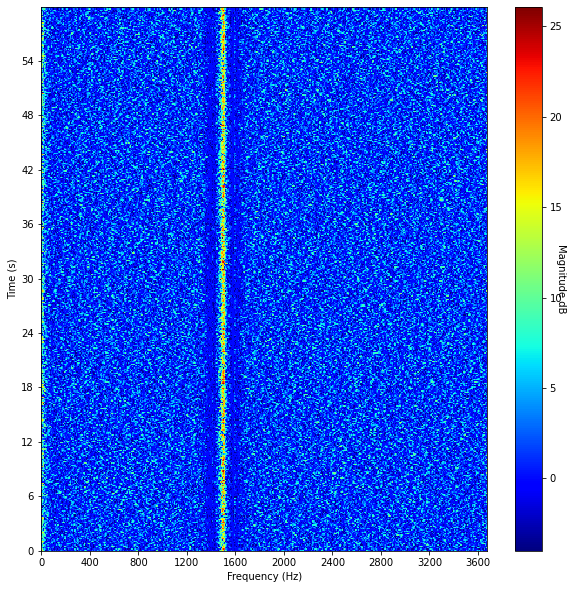

In [6]:
seconds = 60
sample_rate = 22050
f = 1500
t = np.linspace(0, seconds, seconds*sample_rate)
# noise = voss(t.shape[0], 100)
noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(2.0)*10), seconds*sample_rate, sample_rate)
noise = scl(noise)
noise *= 3

amplitude = np.random.lognormal(mean=1, sigma=0.2, size=seconds*sample_rate)

p = 0.003
# p_array = p*np.random.normal(0, 2.3, size=seconds*sample_rate)
p_array = p*np.random.normal(0, np.random.lognormal(0,.9, size=seconds*sample_rate))
large_f = band_limited_noise(f*(1 - p_array) , f*(1 + p_array), samples=seconds*sample_rate, samplerate=sample_rate)
large_f = scl(large_f)

# x = amplitude*(np.sin(2*np.pi*f*t))
# x = scl(x)

x = scl(x)
x = amplitude*large_f

y = x  + noise
y = y[:, np.newaxis] 

sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
# sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

## Random amplitude + noise + narrowband noise with uniform pertubation

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1dea880>)

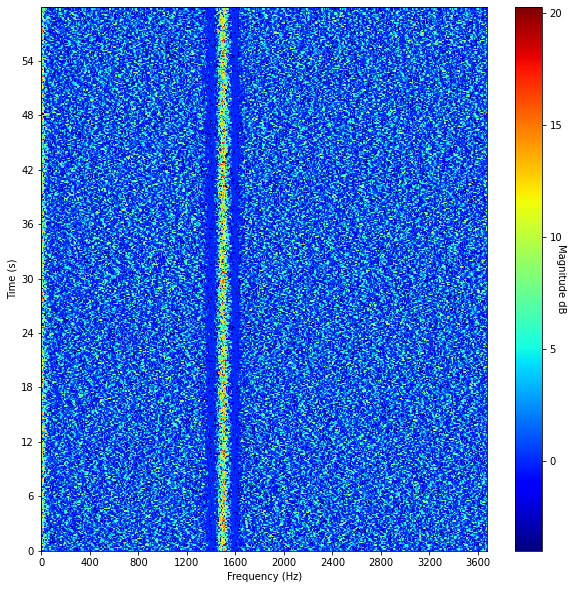

In [7]:
seconds = 60
sample_rate = 22050
f = 1500
t = np.linspace(0, seconds, seconds*sample_rate)
# noise = voss(t.shape[0], 100)
noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(2.0)*10), seconds*sample_rate, sample_rate)
noise = scl(noise)
noise *= 3

amplitude = np.random.lognormal(mean=1, sigma=0.2, size=seconds*sample_rate)

p = 0.003
# p_array = p*np.random.normal(0, 2.3, size=seconds*sample_rate)
p_array = p*np.random.normal(0, np.random.uniform(1.0, 8, size=seconds*sample_rate))
large_f = band_limited_noise(f*(1 - p_array) , f*(1 + p_array), samples=seconds*sample_rate, samplerate=sample_rate)
large_f = scl(large_f)



# x = amplitude*(np.sin(2*np.pi*f*t))
# x = scl(x)

x = scl(x)
x = amplitude*large_f

y = x  + noise
y = y[:, np.newaxis] 

sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
# sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1d2cd90>)

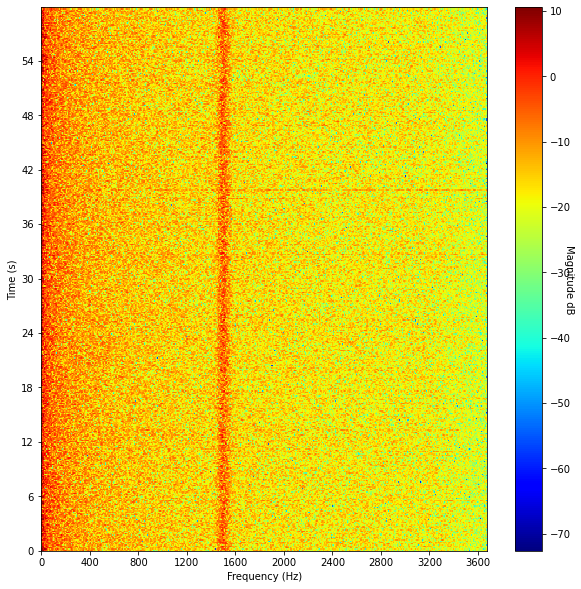

In [8]:
seconds = 60
sample_rate = 22050
f = 1500
t = np.linspace(0, seconds, seconds*sample_rate)
# noise = voss(t.shape[0], 100)
noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(1.8)*10), seconds*sample_rate, sample_rate)
noise = scl(noise)
noise *= 8

amplitude = np.random.lognormal(mean=0, sigma=1.2, size=seconds*sample_rate)

p = 0.009
p_array = p*np.random.normal(0, 2.3, size=seconds*sample_rate)
# p_array = p*np.random.normal(0, 9*(1 + 0.5*np.sin(2*np.pi*0.5*t)))
large_f = band_limited_noise(f*(1 - p_array) , f*(1 + p_array), samples=seconds*sample_rate, samplerate=sample_rate)
large_f = scl(large_f)

x = amplitude*large_f

y = x  + noise
y = y[:, np.newaxis] 

# sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

## Varying noise amplitude

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1c7adf0>)

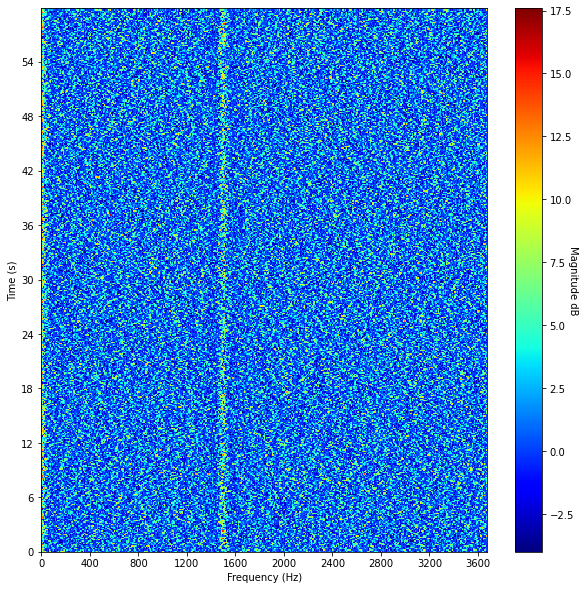

In [9]:
seconds = 60
sample_rate = 22050
f = 1500
t = np.linspace(0, seconds, seconds*sample_rate)
# noise = voss(t.shape[0], 100)
noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(1.8)*10), seconds*sample_rate, sample_rate)
noise = scl(noise)
noise_amplitude = 8 + np.random.exponential(scale=7, size=seconds*sample_rate)
noise *= noise_amplitude

amplitude = np.random.lognormal(mean=0, sigma=1.2, size=seconds*sample_rate)

p = 0.009
p_array = p*np.random.normal(0, 2.3, size=seconds*sample_rate)
# p_array = p*np.random.normal(0, 9*(1 + 0.5*np.sin(2*np.pi*0.5*t)))
large_f = band_limited_noise(f*(1 - p_array) , f*(1 + p_array), samples=seconds*sample_rate, samplerate=sample_rate)
large_f = scl(large_f)

x = amplitude*large_f

y = x  + noise
y = y[:, np.newaxis] 

sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
#sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

## Packing narrow band noise generation in function

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1bcff10>)

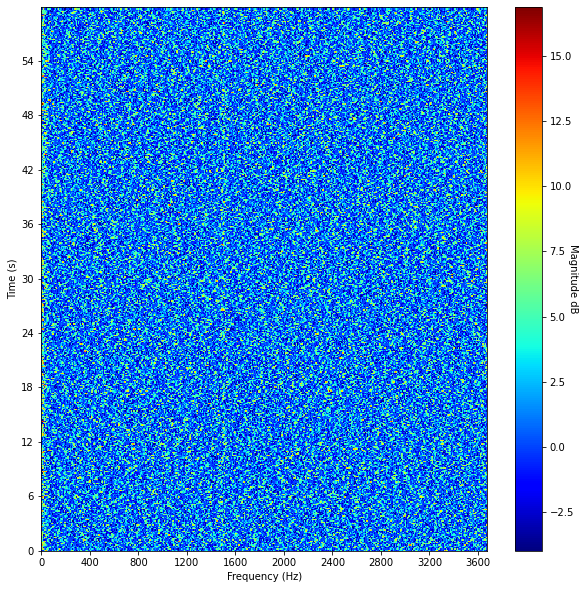

In [10]:
def narrowband_tone(seconds, sample_rate, f, width, signal_amplitude, noise_amplitude, noise_att):
    t = np.linspace(0, seconds, seconds*sample_rate)
    noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(noise_att)*10), seconds*sample_rate, sample_rate)
    noise = scl(noise)
    noise *= noise_amplitude

    x = band_limited_noise(f*(1 - p_array) , f*(1 + p_array), samples=seconds*sample_rate, samplerate=sample_rate)
    x = scl(large_f)

    x *= signal_amplitude

    y = x  + noise
    y = y[:, np.newaxis] 
    
    return y

seconds = 60
sample_rate=22050
f = 1500
p = 0.009
noise_amplitude = 20 + np.random.exponential(scale=10, size=seconds*sample_rate)
noise_att = 1.5
signal_amplitude = np.random.lognormal(mean=0, sigma=1.2, size=seconds*sample_rate)
p_array = p*np.random.normal(0, 2.3, size=seconds*sample_rate)
y = narrowband_tone(seconds, sample_rate, f, p_array, signal_amplitude, noise_amplitude, noise_att)

sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
#sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1b1f1f0>)

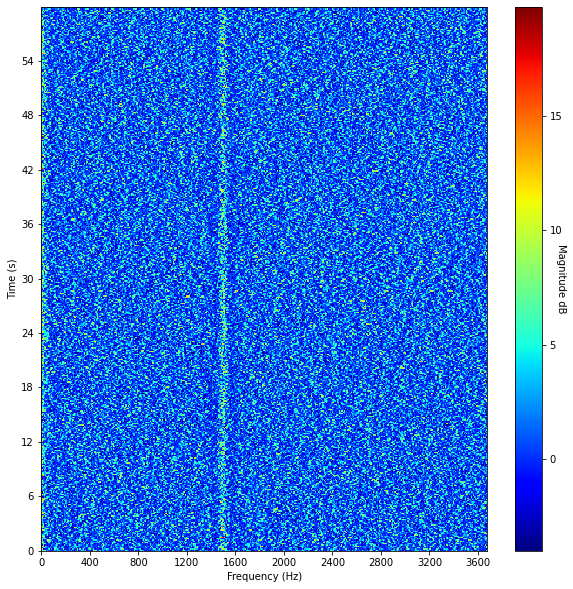

In [11]:
def narrowband_tone(seconds, sample_rate, f, width, signal_amplitude, noise_amplitude, noise_att):
    t = np.linspace(0, seconds, seconds*sample_rate)
    noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(noise_att)*10), seconds*sample_rate, sample_rate)
    noise = scl(noise)
    noise *= noise_amplitude

    x = band_limited_noise(f*(1 - p_array) , f*(1 + p_array), samples=seconds*sample_rate, samplerate=sample_rate)
    x = scl(large_f)

    x *= signal_amplitude

    y = x  + noise
    y = y[:, np.newaxis] 
    
    return y



seconds = 60
sample_rate=22050
f = 1500
p = 0.009

def stochastic_narrowband_tone(seconds, sample_rate, f, width):
    noise_base_value = np.random.uniform(5, 20)
    noise_fluct_limit = 25 - noise_base_value
    
    noise_fluct_scale = np.random.uniform(1, noise_fluct_limit)
    noise_amplitude = noise_base_value + np.random.exponential(scale=noise_fluct_scale, size=seconds*sample_rate)
    
    noise_att = np.random.uniform(1.5, 2.5)
    
    signal_amplitude = np.random.lognormal(mean=0, sigma=1.2, size=seconds*sample_rate)
    width_array = width*np.random.normal(0, 2.3, size=seconds*sample_rate)
    y = narrowband_tone(seconds, sample_rate, f, width_array, signal_amplitude, noise_amplitude, noise_att)
    return y

y = stochastic_narrowband_tone(seconds, sample_rate, f, p)

sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
#sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee1a63700>)

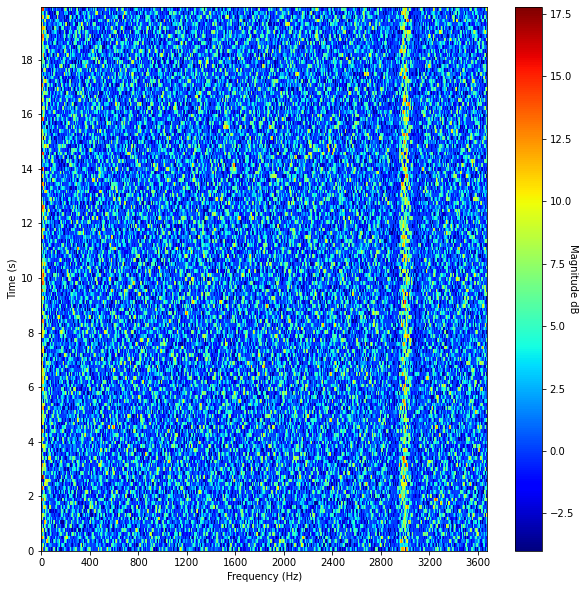

In [12]:
def narrowband_tone(seconds, sample_rate, f, width, signal_amplitude):
    t = np.linspace(0, seconds, seconds*sample_rate)
    
    x = band_limited_noise(f-  width , f + width, samples=seconds*sample_rate, samplerate=sample_rate)
    x = scl(x)

    
    ampl = max(1500/f, f/1500)**0.5
    
    x *= signal_amplitude*ampl
    
    return x



def stochastic_narrowband_tone(seconds, sample_rate, f, width):
    signal_amplitude = np.random.lognormal(mean=0, sigma=1.2, size=seconds*sample_rate)
    width_array = width*(1+np.random.normal(0, 1.8, size=seconds*sample_rate))
    x = narrowband_tone(seconds, sample_rate, f, width_array, signal_amplitude)
    return x

def background_noise(seconds, sample_rate):
    noise_base_value = np.random.uniform(5, 20)
    noise_fluct_limit = 20 - noise_base_value
    
    noise_fluct_scale = np.random.uniform(1, noise_fluct_limit)
    noise_amplitude = noise_base_value + np.random.exponential(scale=noise_fluct_scale, size=seconds*sample_rate)
    
    noise_att = np.random.uniform(1.5, 2.5)
    
    noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(noise_att)*10), seconds*sample_rate, sample_rate)
    noise = scl(noise)
    noise *= noise_amplitude
    
    return noise


seconds = 20
sample_rate=22050
f = 3000
p = 15

x = stochastic_narrowband_tone(seconds, sample_rate, f, p)
noise = background_noise(seconds, sample_rate)

y = x  + noise
y = y[:, np.newaxis] 

sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
#sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()

fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

## Generating random frequencies

In [13]:
def frequency_band_gen(freq_array=None):
    #base_width = np.random.uniform(0.005, 0.010)
    base_width = np.random.uniform(7, 15)
    base_width = np.random.normal(10, 5)
    if freq_array is None:
        center_freq = np.random.uniform(20, 7350//2)
        
        return center_freq, base_width
    else:
        idx = np.random.randint(0, len(freq_array)-1)
        center_freq = freq_array[idx]
        interval_mask = (freq_array > center_freq - base_width) & (freq_array < center_freq +base_width)
        
        freq_interval = np.argwhere(freq_array[interval_mask])
        
        freq_array = np.delete(freq_array, [freq_interval])
        
        return center_freq, base_width, freq_array

def frequency_gen(n=1):
    freq_array = np.arange(100, 7350//2 - 100, 1)
    bands = list()
    for i_freq in range(n):
        center, base, freq_array = frequency_band_gen(freq_array)
        bands.append((center, base))
    return bands

center, base = frequency_gen()[0]



(<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Time (s)'>,
 <matplotlib.colorbar.Colorbar at 0x7fbee193b190>)

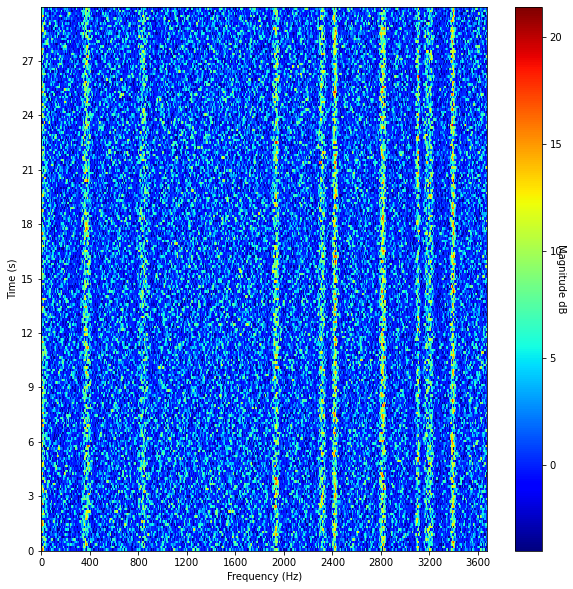

In [14]:
seconds = 30
sample_rate=22050

n_freqs = 10

bands = frequency_gen(n_freqs)
x = np.zeros(seconds*sample_rate)
for f, p in bands:
    x += stochastic_narrowband_tone(seconds, sample_rate, f, p)
    
noise = background_noise(seconds, sample_rate)

y = x  + noise
y = y[:, np.newaxis] 

sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
#sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
sxx = sxx.squeeze()
fig, ax = plt.subplots(figsize=(10,10))
waterfall_spectrogram(ax, freq, time, sxx)

## Frequency gen functions

In [15]:
def frequency_band_gen(freq_array=None):
    #base_width = np.random.uniform(0.005, 0.010)
    base_width = np.random.uniform(7, 15)
    base_width = np.random.normal(10, 5)
    if freq_array is None:
        center_freq = np.random.uniform(20, 7350//2)
        
        return center_freq, base_width
    else:
        idx = np.random.randint(0, len(freq_array)-1)
        center_freq = freq_array[idx]
        interval_mask = (freq_array > center_freq - base_width) & (freq_array < center_freq +base_width)
        
        freq_interval = np.argwhere(freq_array[interval_mask])
        
        freq_array = np.delete(freq_array, [freq_interval])
        
        return center_freq, base_width, freq_array

def frequency_gen(n=1):
    freq_array = np.arange(100, 7350//2 - 100, 1)
    bands = list()
    for i_freq in range(n):
        center, base, freq_array = frequency_band_gen(freq_array)
        bands.append((center, base))
    return bands

## BG noise low order functions

In [16]:
def spectrum_noise(spectrum_func, samples=1024, rate=44100):
    """ 
    make noise with a certain spectral density
    """
    freqs = np.fft.rfftfreq(samples, 1.0/rate)            # real-fft frequencies (not the negative ones)
    spectrum = np.zeros_like(freqs, dtype='complex')      # make complex numbers for spectrum
    spectrum[1:] = spectrum_func(freqs[1:])               # get spectrum amplitude for all frequencies except f=0
    phases = np.random.uniform(0, 2*np.pi, len(freqs)-1)  # random phases for all frequencies except f=0
    spectrum[1:] *= np.exp(1j*phases)                     # apply random phases
    noise = np.fft.irfft(spectrum)                        # return the reverse fourier transform
    noise = np.pad(noise, (0, samples - len(noise)), 'constant') # add zero for odd number of input samples
 
    return noise
 
def pink_spectrum(f, f_min=0, f_max=np.inf, att=np.log10(2.0)*10):
    """
    Define a pink (1/f) spectrum
        f     = array of frequencies
        f_min = minimum frequency for band pass
        f_max = maximum frequency for band pass
        att   = attenuation per factor two in frequency in decibel.
                Default is such that a factor two in frequency increase gives a factor two in power attenuation.
    """
    # numbers in the equation below explained:
    #  0.5: take the square root of the power spectrum so that we get an amplitude (field) spectrum 
    # 10.0: convert attenuation from decibel to bel
    #  2.0: frequency factor for which the attenuation is given (octave)
    s = f**-( 0.5 * (att/10.0) / np.log10(2.0) )  # apply attenuation
    s[np.logical_or(f < f_min, f > f_max)] = 0    # apply band pass
    return s

## Tone low order functions

In [17]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

def scl(x):
    return (x - x.mean())/x.std()

## Tone and BG noise high order functions

In [18]:
def narrowband_tone(seconds, sample_rate, f, width, signal_amplitude):
    t = np.linspace(0, seconds, seconds*sample_rate)
    
    x = band_limited_noise(f-  width , f + width, samples=seconds*sample_rate, samplerate=sample_rate)
    x = scl(x)
    
    ampl = max(1500/f, f/1500)**0.5
    x *= signal_amplitude*ampl
    return x

def stochastic_narrowband_tone(seconds, sample_rate, f, width):
    signal_amplitude = np.random.lognormal(mean=0, sigma=1.2, size=seconds*sample_rate)
    width_array = width*(1+np.random.normal(0, 1.8, size=seconds*sample_rate))
    x = narrowband_tone(seconds, sample_rate, f, width_array, signal_amplitude)
    return x

def background_noise(seconds, sample_rate):
    noise_base_value = np.random.uniform(5, 20)
    noise_fluct_limit = 20 - noise_base_value
    
    noise_fluct_scale = np.random.uniform(1, noise_fluct_limit)
    noise_amplitude = noise_base_value + np.random.exponential(scale=noise_fluct_scale, size=seconds*sample_rate)
    
    noise_att = np.random.uniform(1.5, 2.5)
    
    noise = spectrum_noise(lambda x:pink_spectrum(x, att=np.log10(noise_att)*10), seconds*sample_rate, sample_rate)
    noise = scl(noise)
    noise *= noise_amplitude
    
    return noise


In [1]:
import src.sample_generator as sample_generator

import numpy as np
from pathlib import Path
import sys
from src.features.signal import lofar
from src.visualization import waterfall_spectrogram
import matplotlib.pyplot as plt
import pandas as pd
from time import time



In [ ]:
seconds = 20
sample_rate=22050

start = time()
for i in range(10000):
    if i % 1000 == 0 :
        print(i)
    sxx, mask, freq, _ = sample_generator.gen_sim_lofargram(seconds, sample_rate, return_axis=True)
    #np.save(Path('generated_samples') / f'{i:05d}_sample.npy', sxx)
    #np.save(Path('generated_samples') / f'{i:05d}_mask.npy', mask)
    np.savez_compressed(Path('generated_samples')/ 'train' / f'{i:05d}.npz', sxx, mask)
print(time() - start)    

start = time()
for i in range(5000):
    if i % 500 == 0 :
        print(i)
    sxx, mask, freq, _ = sample_generator.gen_sim_lofargram(seconds, sample_rate, return_axis=True)
    #np.save(Path('generated_samples') / f'{i:05d}_sample.npy', sxx)
    #np.save(Path('generated_samples') / f'{i:05d}_mask.npy', mask)
    np.savez_compressed(Path('generated_samples')/ 'validation' / f'{i:05d}.npz', sxx, mask)
print(time() - start)

for i in range(10):
    sxx, mask, freq, _ = sample_generator.gen_sim_lofargram(seconds, sample_rate, return_axis=True)
    #np.save(Path('generated_samples') / f'{i:05d}_sample.npy', sxx)
    #np.save(Path('generated_samples') / f'{i:05d}_mask.npy', mask)
    np.savez_compressed(Path('generated_samples')/ 'presentation' / f'{i:05d}.npz', sxx, mask)
#sxx, freq, time = lofar(y, sr=sample_rate, final_sr=7350, use_tpsw=False, tonal_threshold=None)
#sxx = sxx.squeeze()

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(20,10))
_, cbar = waterfall_spectrogram(ax, freq, time, sxx)
#cbar.remove()
#_, cbar = waterfall_spectrogram(ax2, freq, time, mask[:, :, 0])
#cbar.remove()

0


/mnt/c/Users/pedro/Documents/Workplace/lps/new_sonar/experiments/segmentation_network_initiative/sample_generator.py:111: RuntimeWarning: invalid value encountered in true_divide
  return (x - x.mean())/x.std()


1000
2000
3000
4000
5000
6000
7000
8000
9000
5304.46363902092
0
500
1000
1500
2000
2500
3000
3500
4000
4500
